## Inverse problems in image processing - TD 4
                                  
                                  e-mail: jayousi@unice.fr
                                  date: 27th Jan. 2023

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.linalg import circulant
import scipy.sparse

# Introduction to Inverse Problems

The observed image $y$ is a result of an degradation of an image $x$ by a linear transformation $f$, and some added noise $\eta$. This is the same as writing:
$$
mat(y)=f(mat(x)) + mat(\eta) \qquad (1)
$$
where $mat(\cdot)$ is a notation used in this lab to underline that $f(mat(x))$ is an operation on a matrix $x$. 

A more common notation to write (1) is: 
$$
y= Ax + \eta
$$
where $A$ is the linear transformation and $x$, $y$ and $\eta$ are viewed as vectors. However, when working in image processing the matrix $A$ will rarely be constructed, and we will not reshape the image $x$ into a vector. Recall that even though we use the above notation, we do not actually construct the matrix. 

In this tutorial, we suppose that the noise $\eta \sim \mathcal{N}(0, \sigma^2 I)$. 
  
The probability density function $p_\eta(\eta)$ is written as: 
\begin{equation}
p_\eta(\eta) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \exp \left(-\frac{\|\eta\|_2^2}{2\sigma^2}\right)
\end{equation}

where $N$ is the number of pixels and $\|\eta\|_p$ is the $l^p$-norm defined as: 
 
 \begin{equation}
  \|\eta\|_p = \left(\sum_{i=1}^N |\eta|^p\right)^{\frac{1}{p}}
 \end{equation}
 
 We want to find the unknown image $x$ from the observation $y$. Therefore, we use the  maximum likelihood estimation which maximizes the likelihood $L(y,x)$ with respect to the unknown image $x$. This likelihood is equal to the conditional probability of $y$ knowing $x$, denoted $p_{y|x}(y|x)$. The probability is calculated from the image model, supposing that the $\eta$ is white Gaussian noise. 

More precisely, the likelihood $L(y,x)$ is given by:
\begin{equation}
 L(y,x) = p_{y|x}(y|x) = p_n(n=Ax - y) = \frac{1}{(2\pi\sigma^2)^{\frac{N}{2}}} \textrm{exp}\left(-\frac{\|Ax-y\|_2^2}{2\sigma^2}\right)
\end{equation}

We search for an estimation $\hat{x}$ of the real image $x$ by maximizing the ligelihood  $L(y,x)$ as follows: 
\begin{equation}
 \hat{x} = \arg\max_x L(y,x)
\end{equation}

In order to avoid the difficulties related to the exponential, we often maximize the logarithm of the likelihood (which does not change the maximum argument since the logarithm is strictly increasing):
\begin{equation}
 \hat{x} = \arg\max_x \, \ln(L(y,x)) = \arg\max_x \, \left(- \ln \left(2\pi\sigma^2 \right)^{\frac{N}{2}} -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The term $- \ln \left( 2\pi\sigma^2 \right)^{\frac{N}{2}}$ is a constant with respect to $x$, and thus does not intervene in the estimation of $\arg\max$. Therefore, we can write:
\begin{equation}
 \hat{x} = \arg\max_x \, \left( -\frac{1}{2\sigma^2}\|Ax-y\|_2^2\right)
\end{equation}

The last step removes the proptionality coefficent $\frac{1}{2\sigma^2}$ and the negative sign by using the fact that  $\arg\max_x -f(x) = \arg\min_x f(x)$. To sum up: 
\begin{equation}
 \hat{x} = \arg\min_x \, \|Ax-y\|_2^2 
\end{equation}


Denote $J(x)=\|Ax-y\|_2^2 $. This term is in fact the Least Square term associated to the system $y = Ax$. The gradient of $J$ is $\nabla J(x)= 2A^*(Ax-y)$, where $A^*$ is the adjoint operator of A.

1. Find the explicit expression for $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$.

$$\nabla J(x)=0 \text{ for } x=(A^*A)^{-1}A^*y$$

In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. The algorithm can be written as:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

## Deconvolution Example

Load the image "boats.png", rescale it to have values in the [0, 255] interval and display it. 

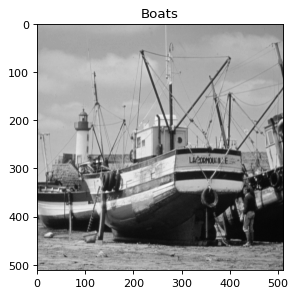

In [2]:
def scale(img):
    return((img - img.min())/(img.max() - img.min()) * 255)

# load the images
x = np.float64(plt.imread('boats.png')) 

# rescale the images in the range 0-255
x = scale(x)

# plot the images
plt.figure(figsize=(4, 4), dpi=80)
plt.imshow(x,cmap='gray') 
plt.title('Boats')
plt.show()

Compute the low pass Gaussian kernel with $\sigma=2$ pixels.  

The steps to create the convolution kernel is: 
1. Create a meshgrid of same size of the image (512x512). The center of the meshgrid could be 0. 
2. Apply the the Gaussian function onto the grid, and normalize the response such that the sum of all elements in the reponse =1. 
3. Apply the Fast Fourier Transformation. NOTE: If the center of the grid was defined as 0, a fftshift has to be done before applying the FFT2. 

In [3]:
sigma = 2
n = x.shape[0]
t = np.concatenate( (np.arange(0,n/2+1), np.arange(-n/2,-1)) )
[Y, X] = np.meshgrid(t,t)
h = np.exp( -(X**2+Y**2)/(2.0*float(sigma)**2) )
h = h / np.sum(h)
hf = np.real(np.fft.fft2(h)) #the Fourier transform (should be real because of symmetry).

Find the blurred image (y_bl) by computing the periodic convolution using FFTs.

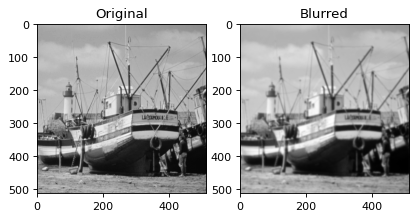

In [4]:
y_bl = np.real(np.fft.ifft2(hf*np.fft.fft2(x))) 

plt.figure(figsize=(6, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray') 
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(y_bl, cmap='gray') 
plt.title('Blurred')
plt.show()

Let y_bl be a blured image (without adding any noise). Compute the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT.

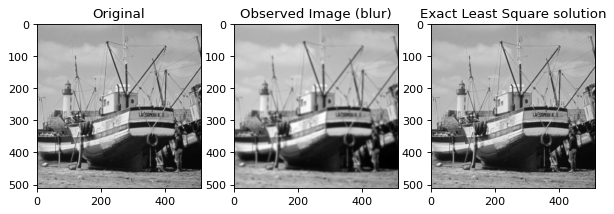

In [5]:
# -- Exact Least Square solution using Fourier
hf_adj = hf.conj().T
xsol = np.real(np.fft.ifft2(hf_adj*np.fft.fft2(y_bl)/(abs(hf)**2)))  

plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(1, 3, 1)
plt.imshow(x, cmap='gray') 
plt.title('Original')
# plot y
plt.subplot(1, 3, 2)
plt.imshow(y_bl,cmap='gray') 
plt.title('Observed Image (blur)')
# plot xsol
plt.subplot(1, 3, 3)
plt.imshow(xsol, cmap= 'gray') 
plt.title('Exact Least Square solution')
plt.show()


2. Add white Gaussian noise (even a little bit) to the blurred image $y$ of the previous question. Compute again the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT. What do you observe?

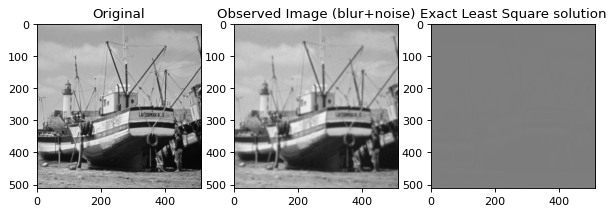

In [8]:
sig = 5                      # SD of Gaussian noise 
y = y_bl + sig * np.random.randn(*x.shape)

hf_adj = hf.conj().T
xsol = np.real( np.fft.ifft2( hf_adj * np.fft.fft2(y) / (abs(hf)**2) ) ) 

plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(1, 3, 1)
plt.imshow(x,cmap='gray') 
plt.title('Original')

# plot y
plt.subplot(1, 3, 2)
plt.imshow(y,cmap='gray') 
plt.title('Observed Image (blur+noise)')

# plot xsol
plt.subplot(1, 3, 3)
plt.imshow(xsol,cmap= 'gray') 
plt.title('Exact Least Square solution')
plt.show()

#### The importance of Matrix Condition number
The matrix condition number can be calculated, for an $A$ invertible, as 
$$
cond(A) = \|A\|\|A^{-1}\|
$$
Where $\|A\|= \sup_{x \neq 0} \frac{\|Ax\|}{\|x\|}$.
It can also be calculated  
$$cond(A) = \frac{\lambda_{max}}{\lambda_{min}}$$

If we have 
$
y=Ax
$, then $\|y\|\leq \|A\|\|x\|$.
If we have a small pertubation, then 
$y+\delta y = A(x+ \delta x)$, and $\delta y= A \delta x$. Which yields  $\|\delta x\|\leq \|A^{-1}\|\|\delta y\|$.
And thus, 

$$\frac{\|\delta x\|}{\|x\|}\leq\|A\| \|A^{-1}\|\frac{\|\delta y\|}{\|y\|}$$
or, equivalently
$$\frac{\|\delta x\|}{\|x\|}\leq cond(A) \frac{\|\delta y\|}{\|y\|}$$

3. Why is the Matrix Condition number important ? What is the condition number for our problem (remember that the eigenvalues of $A$ are given by the coefficients of the Fourier transform of h)?  Is the problem ill-posed? 

In [9]:
t = (np.abs(np.fft.fft2(h)))
print(t.max()//t.min())

1235.0


#### Gradient Descent algorithm
In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. Recall that it is an iterative algorithm, while each update is given by:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

4. Complete the gradient descent function below, plot the cost/error function and the resulting image. What do you observe for different K?

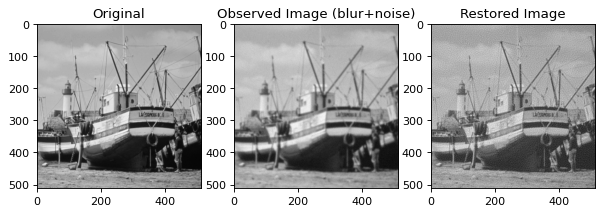

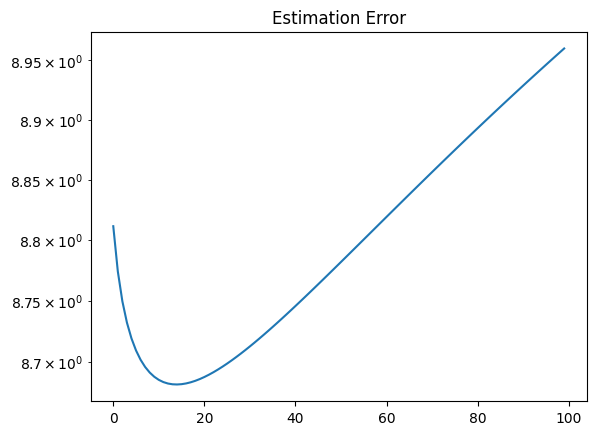

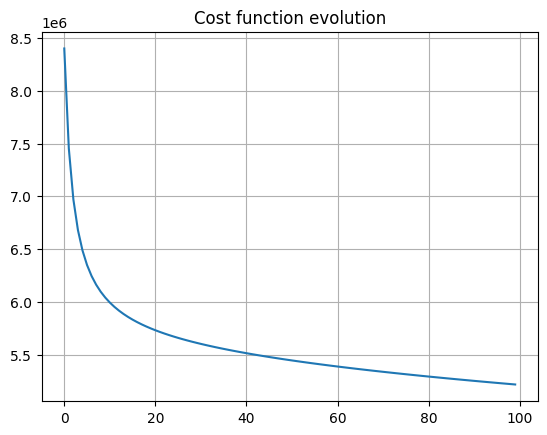

In [23]:
# -- Gradient Descent algo

#-- Parameters
alpha = 0.4                    # Step
K = 100                        # Number of iteration

# Initialisation
xk = y
J = np.zeros(K)    # Cost
err = np.zeros(K)  # Error 

# Loop
k = 0
while k < K:
    #  gradient
    gradJ = 2 * np.real(np.fft.ifft2( hf_adj * np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk)) - y)))
    # update xk
    xk = xk - alpha * gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm( np.real( np.fft.ifft2(hf * np.fft.fft2(xk)) - y ) )**2  #  Cost function
    err[k] = np.linalg.norm(xk - x)  # error between xk and the original image
    k += 1


# -- plots
plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(1, 3, 1)
plt.imshow(x, cmap='gray') 
plt.title('Original')
# plot y
plt.subplot(1, 3, 2)
plt.imshow(y, cmap='gray') 
plt.title('Observed Image (blur+noise)')
# plot xk
plt.subplot(1, 3, 3)
plt.imshow(xk, cmap= 'gray') 
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err)) 
plt.title('Estimation Error')

# Cost Function 
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

We obtain better reconstruction with early stopping (can be seen as an alternative to regularisation).

## Tikhonov Regularisation

As we can observe from the above example, the minimization of the least square term does not yield good results when we have noisy data. Since the problem is ill posed we must add a regularisation term to the minization. The choice of regularization depends on the image model.
Natural images are piecewise constant. Thus the norm of the gradient should be quite small. For this we choose: 

$$
 p_x(x) = \frac{1}{Z} \exp (-\lambda \|\nabla x\|_2^2)
$$
where $Z$ is a normalization constant and $\lambda$ is a regularization factor. We will now use the maximum a posteriori estimation. This estimation maximises the conditional probability of $x$ knowing $y$, denoted 
 $p_{x|y}(x|y)$:
$$
 \hat{x} = \arg\max_x \, \ln(p_{x|y}(x|y))
$$

Bayes law states that $p_{x|y}(x|y)$ is proportional to  $p_{y|x}(y|x)p_x(x)$, and thus :
\begin{align}
 \hat{x} &= \arg\max_x \, \ln(p_{y|x}(y|x)p_x(x)) = \arg\max_x \, \ln(p_{y|x}(y|x)) + \ln(p_x(x)) \nonumber \\
	&=  \arg\max_x \, \left( -\|Ax-y\|_2^2 - \lambda \|\nabla x\|_2^2\right)
\end{align}
Using the same techiques as before we obtain:

\begin{equation}
 \hat{x} =  \arg\min_x \,  \|Ax-y\|_2^2 + \lambda \|\nabla x\|_2^2
\end{equation}
where $\lambda$ is a regularization parameter that controls the weight of the regularization.

Let  $J(x) = \|Ax-y\|_2^2 + \lambda \|\nabla x\|_2^2$, the gradient is defined by
$$
\nabla J(x)= 2A^*(Ax-y)  -2\lambda \Delta x 
$$
where $\Delta$ is the laplacian function (divergence of the gradient).

Implement the gradient descent alogrithm

\begin{equation}
 x_{k+1} = x_k - \alpha \nabla J(x_k)
\end{equation}
with $\lambda = 1$ et $0 < \alpha \leq \frac{1}{2(1 + 8\lambda)}$,

5. Complete the gradient descent function below, plot the cost/error function and the resulting image. What do you observe for the error/cost function?

Iter 10/100
Iter 20/100
Iter 30/100
Iter 40/100
Iter 50/100
Iter 60/100
Iter 70/100
Iter 80/100
Iter 90/100
Iter 100/100


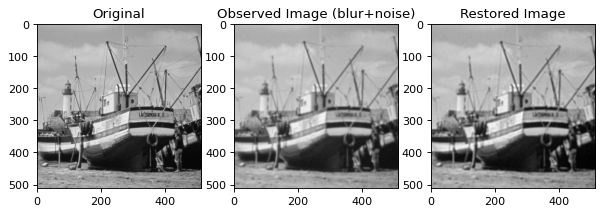

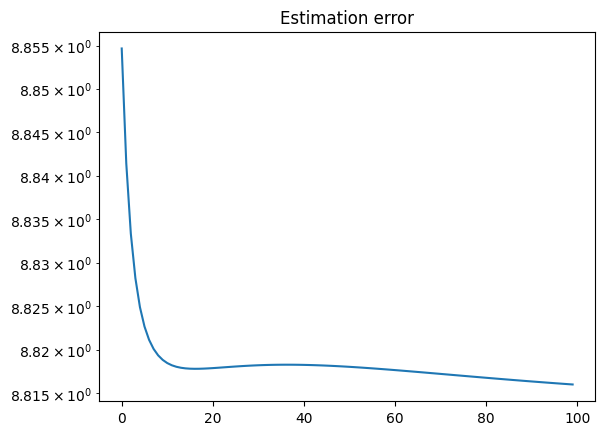

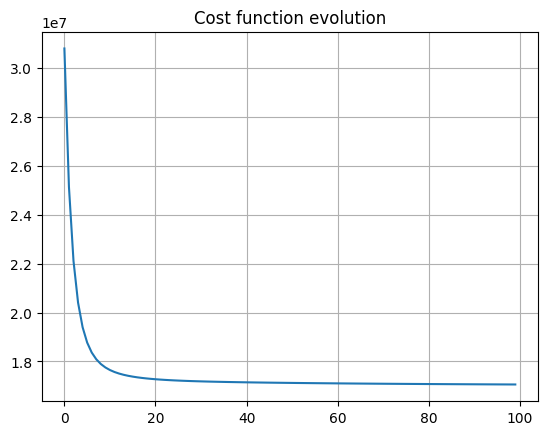

In [14]:
def grad2(u):
    dx = np.zeros(u.shape)
    dy = np.zeros(u.shape)
    dx[:, 0:-1] = u[:,1:] - u[:,0:-1]
    dy[0:-1, :] = u[1:,:] - u[0:-1,:]
    return dx, dy

def div2(dx, dy):
    d1 = np.zeros(dx.shape)
    d2 = np.zeros(dx.shape)
    d1[:, 1:-1] = dx[:, 1:-1]-dx[:, 0:-2]
    d1[:, 0] = dx[:,0]
    d1[:, -1] = -dx[:,-1]
    d2[1:-1, :] = dy[1:-1, :] - dy[0:-2,:]
    d2[0, :] = dy[0, :]
    d2[-1, :] = -dy[-1, :]
    return d1 + d2


lambd = 0.5
alpha = 1/( 4 * (1 + 8*lambd))              # gradient descent step
K = 100                # number of iterations of gradient descent

# -- Gradient descent 
# Initialization
xk = y
J = np.zeros(shape=(K))   # Cost function 
err = np.zeros(shape=(K))  # Error w.r.t the original image
# Main loop
k = 0
while k < K:
    if (k + 1) % 10 == 0:
        print(f'Iter {k+1}/{K}')
    dx, dy = grad2(xk)
    # Computation of the gradient
    gradJ = 2*np.real(np.fft.ifft2( hf_adj * np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk)) - y) ) - lambd*div2(dx,dy))
    # update xk
    xk = xk - alpha * gradJ
    # Computation of the error and the cost function  
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk))-y))**2 + lambd*(np.linalg.norm(dx)**2+np.linalg.norm(dy)**2)  #  Cost function
    err[k] = np.linalg.norm(xk - x) # error between xk and the original image
    k += 1

# -- plots
plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(1, 3, 1)
plt.imshow(x, cmap='gray') 
plt.title('Original')
# plot y
plt.subplot(1, 3, 2)
plt.imshow(y, cmap='gray') 
plt.title('Observed Image (blur+noise)')
# plot xk
plt.subplot(1, 3, 3)
plt.imshow(xk, cmap= 'gray') 
plt.title('Restored Image')
plt.show()


# Error of estimation
plt.figure()
plt.semilogy(np.log(err)) 
plt.title('Estimation error')

# Cost Fonction 
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

6. Observe the restored image, and compare it to the true image. 
More specificaly: Compute the SNR between the Original and the Restored image. Compare it with the SNR between the Original and the Obesrved Image. The function to compute the SNR is given.

In [16]:
snr = lambda xref, x: 20 * np.log10(np.linalg.norm(xref) / np.linalg.norm(xref - x))

snr1 = snr(x, y)
print('SNR:',"{:.2f}".format(snr1), 'dB')

snr2 = snr(x, xk)
print('SNR:',"{:.2f}".format(snr2), 'dB')

SNR: 20.70 dB
SNR: 21.23 dB


7. Compare the solution with the Solution without regularization and comment.

Regularisation methods are a key tool in the solution of inverse problems as they are used to introduce prior knowledge and to allow a robust approximation of ill-posed (pseudo-) inverses. 

You can compare the two reconstructions (with and without regularization) visually or by using the SNR metric.

8. Modify $\lambda$ to observe the influece. 

Bigger the parameter λ, smoother (more blurry) the reconstructed image and with less noisy. Smaller the parameter λ, sharper the reconstruction but more noisy.

# Regularisation by Total Variation (TV)

Here, we use a different regularisation term: the Total Variation (TV). We are considering the $\ell^1$ norm rather the $\ell^2$ norm as for Tikhonov. We aim to minimise:
$$ \|Ax-y\|_2^2 + \lambda \|\nabla x\|_1 $$

So we wish to find $ \hat{x}$, such that:
\begin{equation}
 \hat{x} =  \arg\min_x \,  \|Ax-y\|_2^2 + \lambda \|\nabla x\|_1, \qquad (2)
\end{equation}
where $\lambda$ is a regularization parameter that controls the weight of the regularization and
$$\|\nabla x \|_1 = \sum_{i,j}|(\nabla x)_{i,j}|$$
with
\begin{align}
&(\nabla x)_{i,j} = \big( (\nabla x)_{i,j}^1,(\nabla x)_{i,j}^2 \big)\\
&(\nabla x)_{i,j}^1 = (x_{i+1,j}-x_{i,j})\quad\text{if}\quad i<N,\qquad 0 \quad\text{if}\quad i=N \\
&(\nabla x)_{i,j}^2 = (x_{i,j+1}-x_{i,j})\quad\text{if}\quad j<N,\qquad 0 \quad\text{if}\quad j=N \\
\end{align}
where $N \times N$ is the size of the image.

The TV prior promotes sparsity (l1-norm) on the gradient and is able to reconstruct well sharp edges.

A way to solve the optimization problem (2) is by using the Alternating Direction Method of Multipliers (ADMM) algorithm.

In general, using ADMM we can solve an optimization problem of the form:
$$\arg\min_{x,y} f(x)+g(y) \text{ such that } Ax + By = c$$

Our optimization problem (2) adapts to this form, as:
\begin{align}
&f(x) = \|Ax-y\|_2^2\\
&g(y) = \lambda \|y\|_1\\
& y - \nabla x =0
\end{align}


To solve the optimization problem by using the ADMM algorighm we will make use of the SParse Optimization Research COde (SPORCO) that is a Python package for solving optimisation problems with sparsity-inducing regularisation. 

More details here: https://conference.scipy.org/proceedings/scipy2017/brendt_wohlberg.html

_NB_: You might need to pip install the module if you don't already have it.

In [17]:
from sporco.admm import tvl2
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

9. Fill in the gaps below, plot the resulting image. 

Itn   Fnc       DFid      RegTV     r         s         ρ       
----------------------------------------------------------------
   0  1.37e+07  1.20e+07  8.47e+05  4.26e-01  1.25e+01  4.10e+00
   1  8.19e+06  5.80e+06  1.20e+06  2.40e-01  4.19e+00  4.10e+00
   2  6.80e+06  4.23e+06  1.29e+06  1.59e-01  1.92e+00  9.81e-01
   3  6.52e+06  3.55e+06  1.48e+06  1.61e-01  8.35e-01  2.83e-01
   4  6.62e+06  3.41e+06  1.60e+06  2.06e-01  5.32e-01  1.24e-01
   5  6.67e+06  3.38e+06  1.65e+06  2.25e-01  3.57e-01  7.72e-02
   6  6.62e+06  3.37e+06  1.62e+06  2.00e-01  2.48e-01  6.13e-02
   7  6.52e+06  3.36e+06  1.58e+06  1.66e-01  1.79e-01  5.50e-02
   8  6.39e+06  3.36e+06  1.51e+06  1.28e-01  1.38e-01  5.50e-02
   9  6.30e+06  3.36e+06  1.47e+06  9.93e-02  1.09e-01  5.50e-02
  10  6.23e+06  3.36e+06  1.43e+06  7.78e-02  8.91e-02  5.50e-02
  11  6.18e+06  3.36e+06  1.41e+06  6.18e-02  7.44e-02  5.50e-02
  12  6.15e+06  3.36e+06  1.40e+06  5.33e-02  6.19e-02  5.01e-02
  13  6.12e+06  3.36e+06 

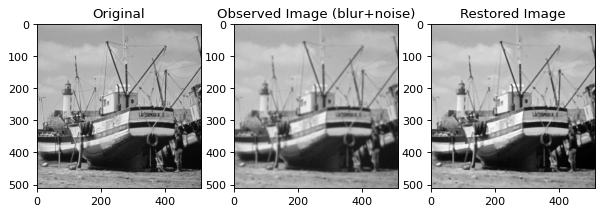

In [19]:
lmbda = 2  # the regularization parameter
opt = tvl2.TVL2Deconv.Options({'Verbose': True, 'MaxMainIter': 200,
                               'gEvalY': False})

b = tvl2.TVL2Deconv(h, y, lmbda, opt)  # first argument: the convolution kernel, second argument: the observed image 
x_tv = b.solve()

# -- plots
plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(1, 3, 1)
plt.imshow(x, cmap='gray') 
plt.title('Original')
# plot y
plt.subplot(1, 3, 2)
plt.imshow(y, cmap='gray') 
plt.title('Observed Image (blur+noise)')
# plot xk
plt.subplot(1, 3, 3)
plt.imshow(x_tv, cmap= 'gray') 
plt.title('Restored Image')
plt.show()

10. Observe the restored image, and compare it to the true image. 
More specificaly: Compute the SNR between the Original and the Restored image. Compare it with the SNR between the Original and the Obesrved Image. The function to compute the SNR is given.

In [21]:
snr3 = snr(x,x_tv)
print('SNR:',"{:.2f}".format(snr3), 'dB')

SNR: 21.66 dB


11. Modify $\lambda$ to observe the influece. 

With a high parameter λ we can remove the noise, but we may lose details of the original image.

12. Compare the result obtained using the Thikhonov and the TV regularization. Plot some zooms to justify your response.

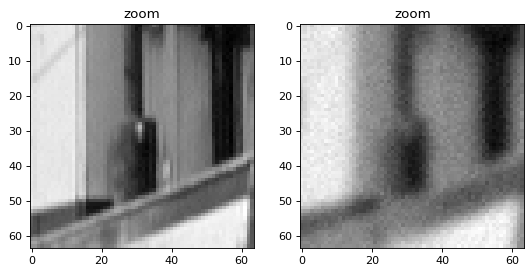

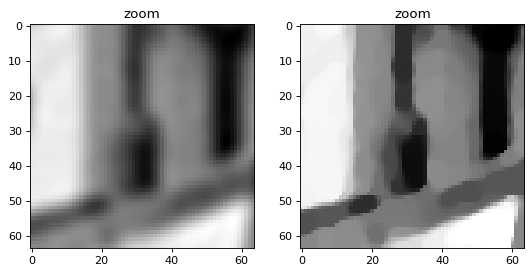

In [22]:
n0 = 512
plt.figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 2, 1)
plt.title('zoom')
plt.imshow(x[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.subplot(2, 2, 2)
plt.title('zoom')
plt.imshow(y[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.figure(figsize=(8, 8), dpi=80)
plt.subplot(2, 2, 3)
plt.title('zoom')
plt.imshow(xk[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.subplot(2, 2, 4)
plt.title('zoom')
plt.imshow(x_tv[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 

plt.show()